In [26]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.regression.linear_model import OLS
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA

In [27]:
# matplotlib library load
import matplotlib.pyplot as plt


# plot 한글 보이게
from matplotlib import rc
rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

In [28]:
train_data = pd.read_csv(r"../data/Train_Data.csv", encoding='CP949')
val_data = pd.read_csv(r"../data/Validation Data.csv", encoding='CP949')
test_data = pd.read_csv(r"../data/Test_Data.csv", encoding='CP949')

C:\Users\user\AppData\Local\Temp\ipykernel_17492\3130063259.py:1: DtypeWarning: Columns (3,4,9,12,18,20,26,27,28,30,32,36,37,44,48,50,54,56,61,63,65,66,68,71,72,73,75,77,80,82,89,91,92,94,96,108,109,112,113,115,116,119,124,130,131,132,133,136,142,143,146,152,153,154,155,158,161,162,163,166,168,169,173,174,175,180,183,185,186,187,192,194,198,199,202,203,204,207,209,210,212,215,216,217,218,220,222,230,231,232,236,245,248,250,251,252,258,259,260,261,262,263,267,269,271,276,279,282,285,286,287,288,290,293,294,295,297,299,300,302,303,312,314,317,318,319,322,323,325,327,328,340,351,353,357,365,374,379,391,393,395,397,399,400,402,405,406,408,410,413,415,416,419,422,423,427,438,439,445,446,448,450,451,454,464,465,467,468,473,475,477,486,493,495,496,498,499,504,506,508,510,511,517,519,521,526,543,546,558,560,561,562,565,571,572,574,576,579,580,586,591,596,599,600,601,605,616,622,623,625,627,635,639,641,643,648,652,659,663,667,671,678,679,680,684,687,689,690,695,698,700,703,704,711,716,719,721,7

In [29]:
train_data.columns = train_data.iloc[0]
train_data = train_data.iloc[1:]
train_data.set_index('Symbol Name', inplace=True)
train_data = train_data.replace(',', '', regex=True).astype(float)

val_data.columns = val_data.iloc[0]
val_data = val_data.iloc[1:]
val_data.set_index('Symbol Name', inplace=True)
val_data = val_data.replace(',', '', regex=True).astype(float)

test_data.columns = test_data.iloc[0]
test_data = test_data.iloc[1:]
test_data.set_index('Symbol Name', inplace=True)
test_data = test_data.replace(',', '', regex=True).astype(float)

In [30]:
total_data = pd.concat([train_data, val_data, test_data])
total_data = total_data.dropna(axis=1)

In [31]:
train_data = total_data.iloc[:2964]
val_data = total_data.iloc[2979:2979+988]
test_data = total_data.iloc[2979+988:]

In [32]:
with open('custum_0.json', 'r', encoding='utf-8') as f:
    groups = json.load(f)

In [33]:
groups

{'KMeans': [['유한양행', '한미사이언스', '대웅', '녹십자홀딩스', '동아쏘시오홀딩스', '종근당홀딩스'],
  ['쌍용C&E', '한일현대시멘트', '현대코퍼레이션', '동양', '성신양회', '금호건설', '우리종금'],
  ['동서', '콜마홀딩스', '태경케미컬', '무학', 'KH 필룩스', '한국내화', '황금에스티', '인팩', '부국철강'],
  ['삼성전자', 'SK하이닉스', '삼성SDI', '삼성전기'],
  ['동원산업', '사조대림', '사조산업', '신라교역', '사조오양', '한성기업', '동원수산'],
  ['디아이', '신성이엔지', '코리아써키트', '케이씨', '광전자', '미래산업'],
  ['POSCO홀딩스', '한국전력', 'SK텔레콤', 'KT'],
  ['SK가스', 'E1', '삼천리', '한국쉘석유', '예스코홀딩스', '경동인베스트', '동방아그로', '부산가스'],
  ['삼화콘덴서', '삼화전기', '삼화전자', '성문전자'],
  ['현대차', '기아', '현대모비스', '한국앤컴퍼니']],
 'DBSCAN': [],
 'Hierarchical': [['삼성전자',
   'SK하이닉스',
   'POSCO홀딩스',
   '삼성SDI',
   '한국전력',
   '삼성전기',
   'SK텔레콤',
   'KT'],
  ['삼성화재',
   'DB손해보험',
   'CJ',
   '현대해상',
   '신세계',
   '코리안리',
   '롯데손해보험',
   '한화손해보험',
   '흥국화재',
   '메리츠화재'],
  ['동서',
   '콜마홀딩스',
   '태경케미컬',
   '에스제이지세종',
   '무학',
   'KH 필룩스',
   '한국내화',
   '황금에스티',
   '인팩',
   '부국철강'],
  ['동원산업', '사조대림', '사조산업', '신라교역', '사조오양', '한성기업', '동원수산'],
  ['SK가스', 'E1', '삼천리', '예스코홀딩스', '경동인베스트

In [34]:
test_num = 4
algorithm = "KMeans"
df = train_data[groups[algorithm][test_num]]

In [35]:
def engle_granger_test(cols):
    y1 = df[cols[0]]
    y2 = df[cols[1]]
    model = OLS(y1,y2).fit()  
    residuals = model.resid  

    adf_test = adfuller(residuals)  
    adf_statistic = adf_test[0]
    critical_values = adf_test[4]
    p_value = adf_test[1]
    result = {
        'columns': cols,
        'adf_statistic': adf_test[0],  # ADF 통계량
        'p_value': adf_test[1],  # p-값
        'critical_values': adf_test[4],  # 임계값
    }
    return result

def get_pair(df):
    import itertools
    all_combinations  = list(itertools.combinations(df.columns, 2))

    results = []  # 결과를 저장할 리스트
    for combination in all_combinations:
        result = engle_granger_test(list(combination))
        results.append(result)

    results_sorted = sorted(results, key=lambda x: x['p_value']) 
    return results_sorted

results_sorted = get_pair(df)

In [36]:
def asset_selection(sets):    
    first_pair = sets[0]['columns']  # 가장 연관성이 큰 첫 번째 쌍
    asset1 = set()  # 첫 번째 그룹
    asset2 = set()  # 두 번째 그룹

    asset1.add(first_pair[0])  # 첫 번째 요소를 asset1에 추가
    asset2.add(first_pair[1])  # 두 번째 요소를 asset2에 추가
    # 나머지 쌍을 그룹에 배치
    for pair in sets[1:]:
        a, b = pair['columns']

        if a in asset1 and b in asset2:
            continue  # 이미 다른 그룹에 배치된 경우 건너뜀
        elif a in asset2 and b in asset1:
            continue  # 이미 다른 그룹에 배치된 경우 건너뜀
        elif a in asset1 and b not in asset1:
            asset2.add(b)  # a가 asset1에 있으면 b를 asset2에 배치
        elif a in asset2 and b not in asset2:
            asset1.add(b)  # a가 asset2에 있으면 b를 asset1에 배치
        elif b in asset1 and a not in asset1:
            asset2.add(a)  # b가 asset1에 있으면 a를 asset2에 배치
        elif b in asset2 and a not in asset2:
            asset1.add(a)  # b가 asset2에 있으면 a를 asset1에 배치
        elif (a not in asset1 and b not in asset2) or (b not in asset1 and a not in asset2):
            # a, b 모두 기존 그룹에 속하지 않은 경우 서로 다른 그룹에 배치
            asset1.add(a)
            asset2.add(b)
        else:
            sets.pop()
            continue

    # 결과 출력
    print("Asset 1:", list(asset1))  # 첫 번째 그룹의 요소
    print("Asset 2:", list(asset2))  # 두 번째 그룹의 요소
    return asset1, asset2

def select_result(results_sorted):
    selected_results = [
        result for result in results_sorted 
        if result['adf_statistic'] < result['critical_values']['5%']
    ]
    selected_results
    asset1, asset2 = asset_selection(selected_results)
    selected_results
    filtered_results=[]
    for result in selected_results:
        asset1_name, asset2_name = result['columns']
        current_columns = result['columns']
        if not (all(column in asset1 for column in current_columns) or all(column in asset2 for column in current_columns)):
            filtered_results.append(result)
        selected_results = filtered_results
        if asset1_name not in asset1 or asset2_name not in asset2:
            # 두 자산의 순서가 리스트 순서와 일치하지 않는 경우, 순서를 바꿉니다.
            result['columns'] = [asset1_name, asset2_name]
    return selected_results, asset1, asset2

selected_results, Asset1, Asset2 = select_result(results_sorted)
selected_results

Asset 1: ['사조대림']
Asset 2: ['사조산업', '신라교역', '동원수산', '사조오양', '한성기업']


[{'columns': ['사조대림', '한성기업'],
  'adf_statistic': -5.25352319358917,
  'p_value': 6.82950640204559e-06,
  'critical_values': {'1%': -3.4325754392267975,
   '5%': -2.862523252048813,
   '10%': -2.567293412144613}},
 {'columns': ['사조대림', '사조오양'],
  'adf_statistic': -4.910225484991651,
  'p_value': 3.3310807449201134e-05,
  'critical_values': {'1%': -3.432577713619062,
   '5%': -2.8625242565537934,
   '10%': -2.567293946934166}},
 {'columns': ['사조대림', '사조산업'],
  'adf_statistic': -4.541110544744947,
  'p_value': 0.00016560733169753748,
  'critical_values': {'1%': -3.4325761968413655,
   '5%': -2.862523586655913,
   '10%': -2.5672935902864547}},
 {'columns': ['사조대림', '신라교역'],
  'adf_statistic': -4.287254222449346,
  'p_value': 0.000467337928278817,
  'critical_values': {'1%': -3.4325754392267975,
   '5%': -2.862523252048813,
   '10%': -2.567293412144613}},
 {'columns': ['사조대림', '동원수산'],
  'adf_statistic': -4.073193776026631,
  'p_value': 0.0010721967543174335,
  'critical_values': {'1%': -3

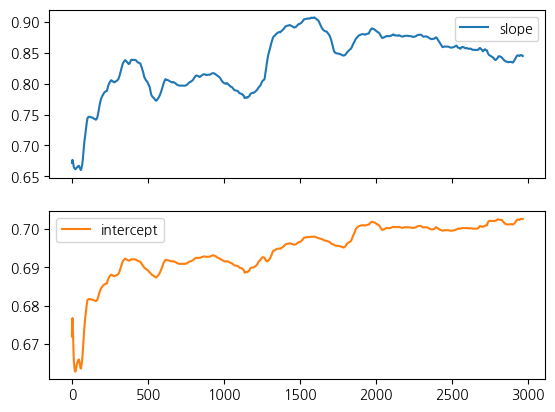

C:\Users\user\AppData\Local\Temp\ipykernel_17492\282360678.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels([p for p in df[::len(df)//9].index]); # [str(p.date())


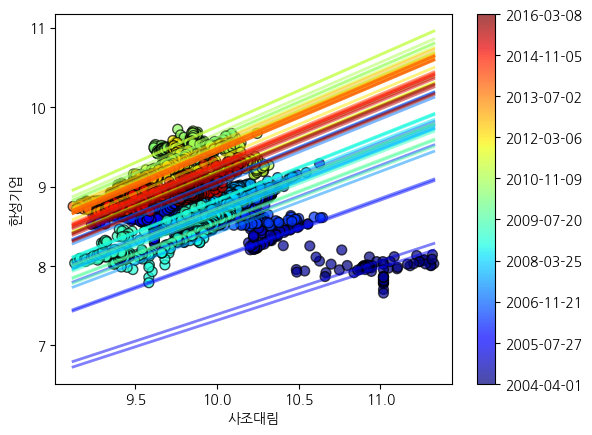

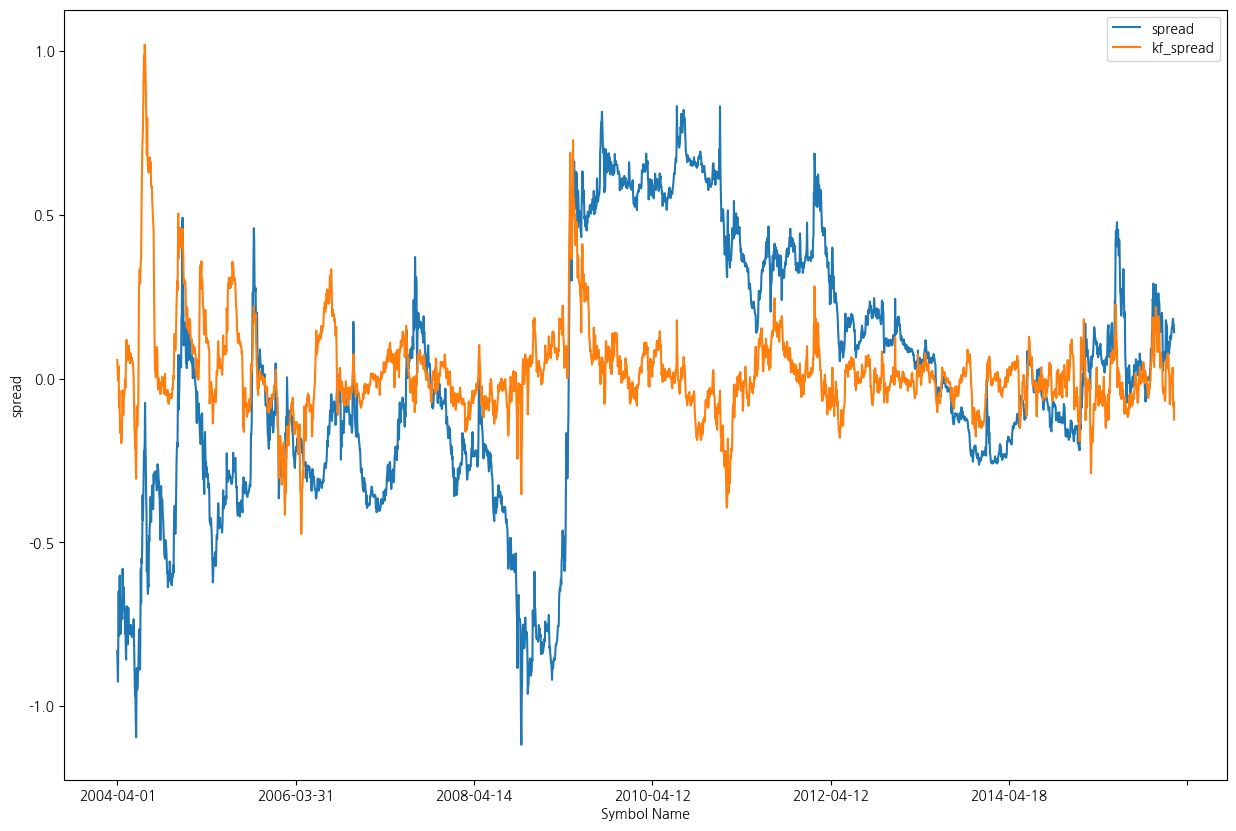

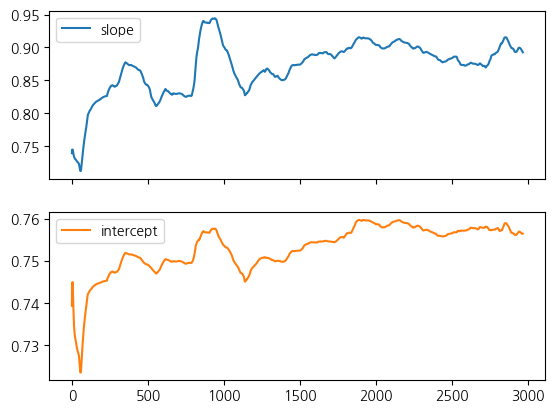

C:\Users\user\AppData\Local\Temp\ipykernel_17492\282360678.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels([p for p in df[::len(df)//9].index]); # [str(p.date())


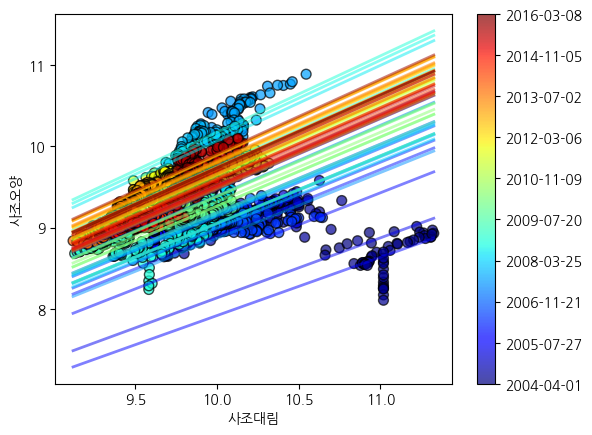

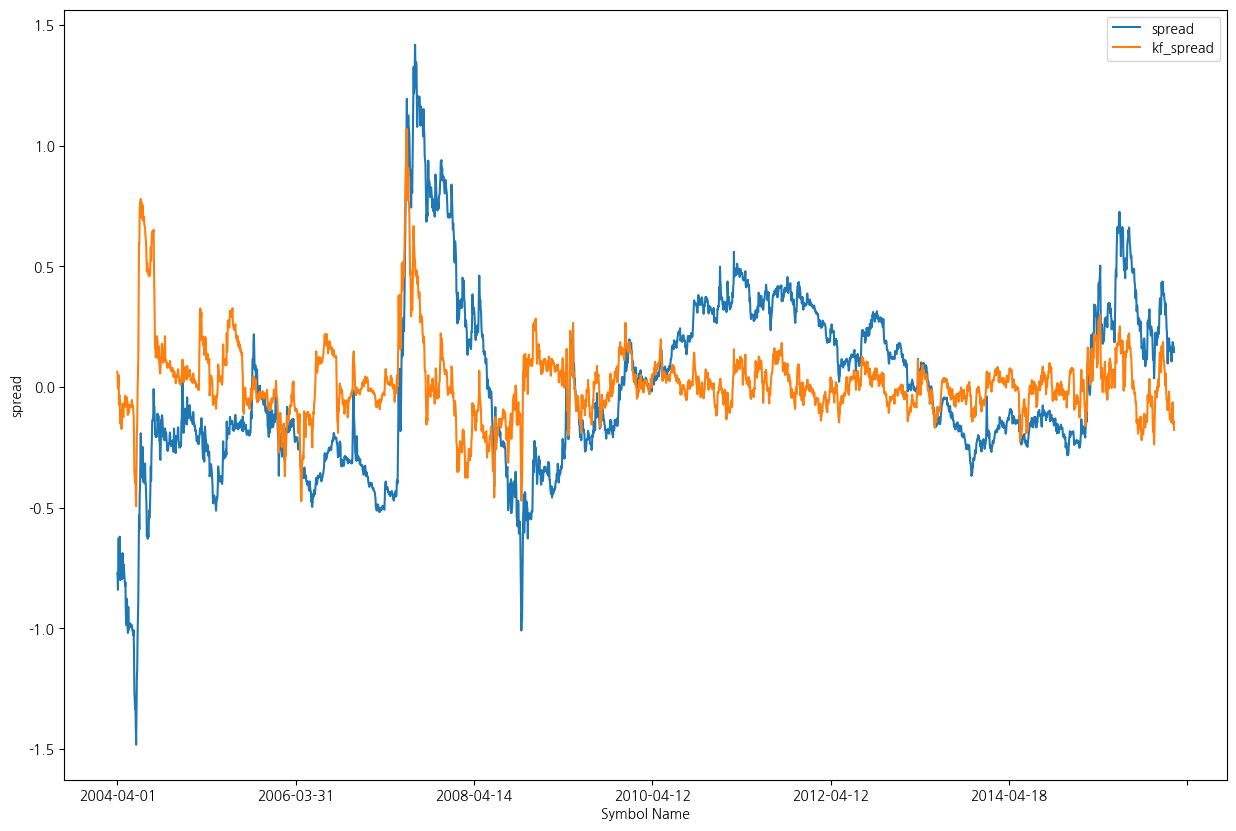

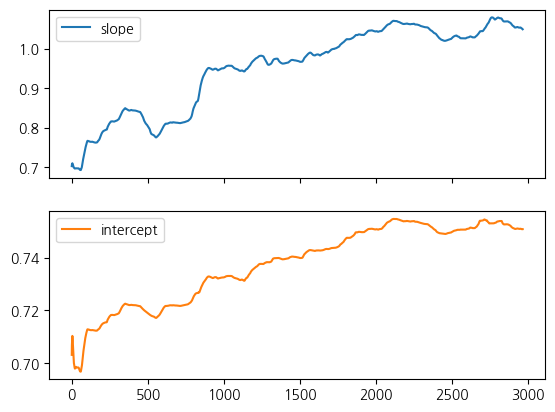

C:\Users\user\AppData\Local\Temp\ipykernel_17492\282360678.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels([p for p in df[::len(df)//9].index]); # [str(p.date())


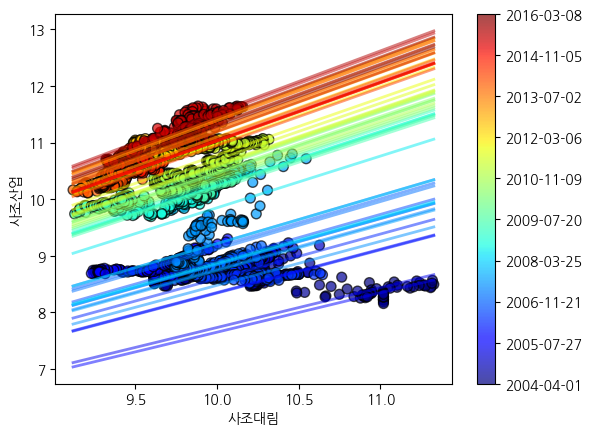

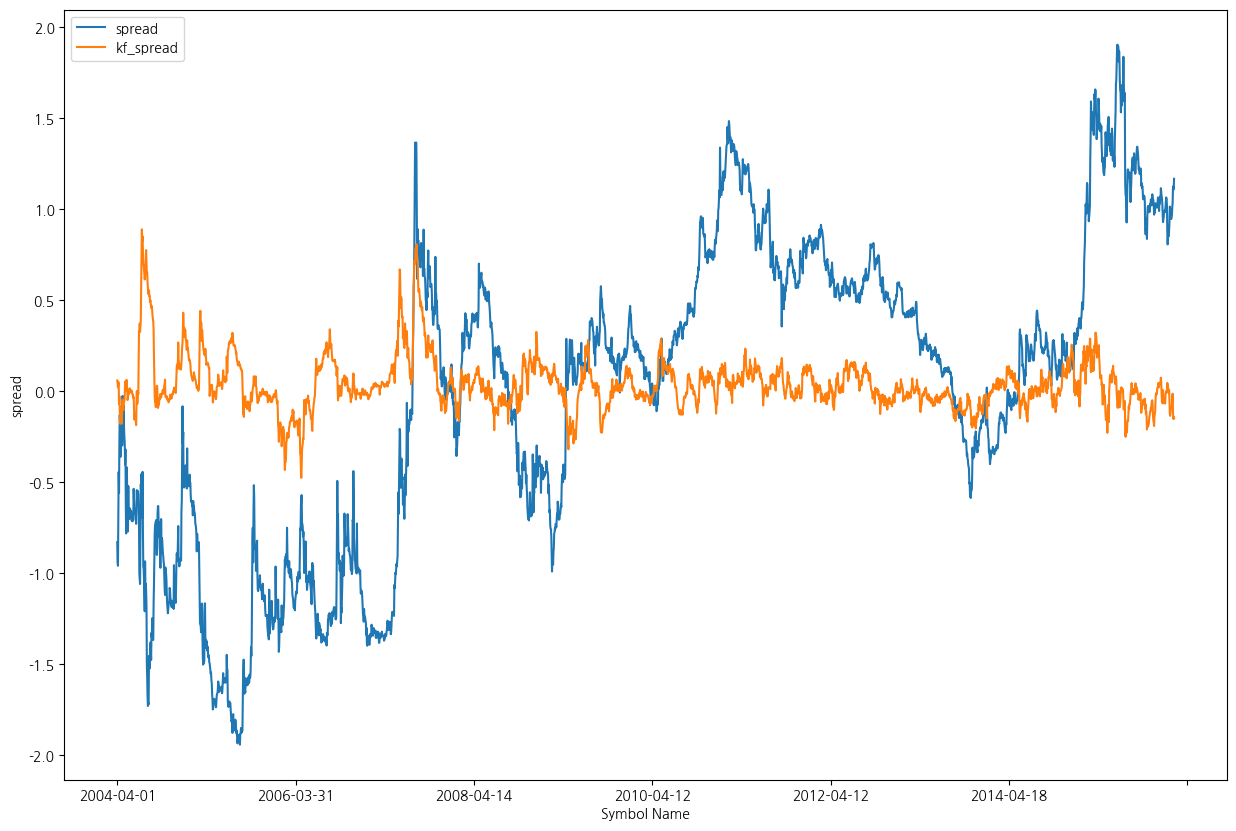

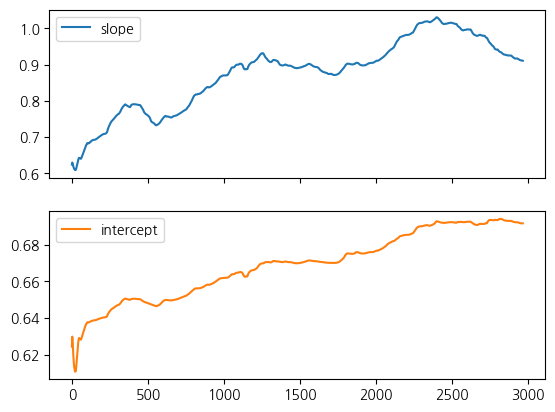

C:\Users\user\AppData\Local\Temp\ipykernel_17492\282360678.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels([p for p in df[::len(df)//9].index]); # [str(p.date())


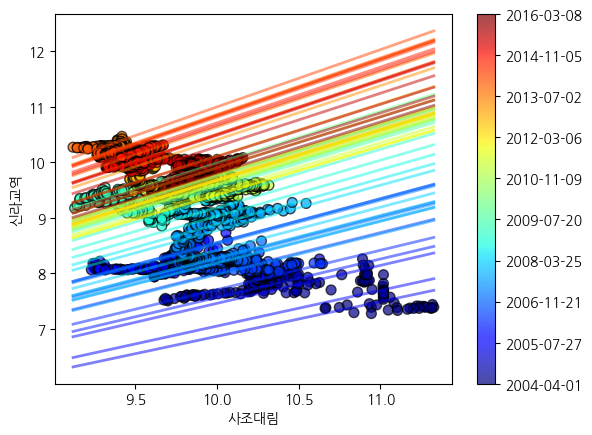

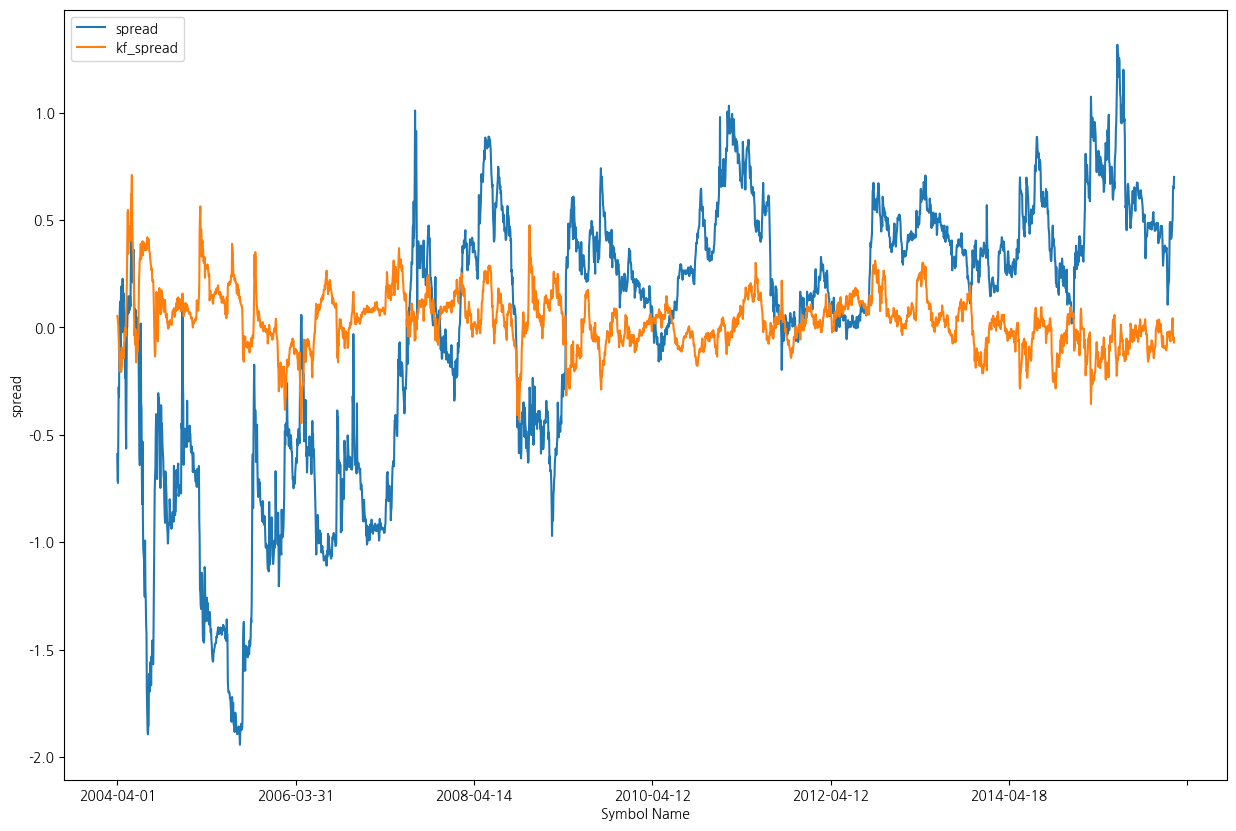

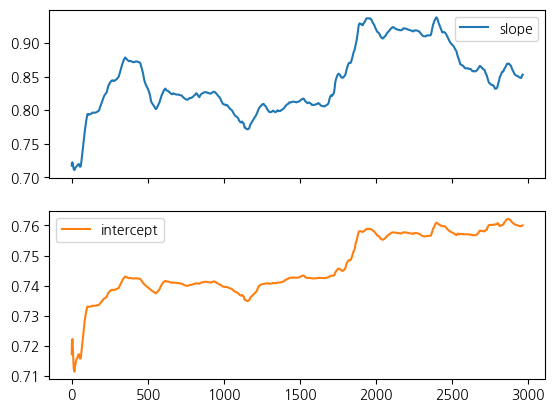

C:\Users\user\AppData\Local\Temp\ipykernel_17492\282360678.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels([p for p in df[::len(df)//9].index]); # [str(p.date())


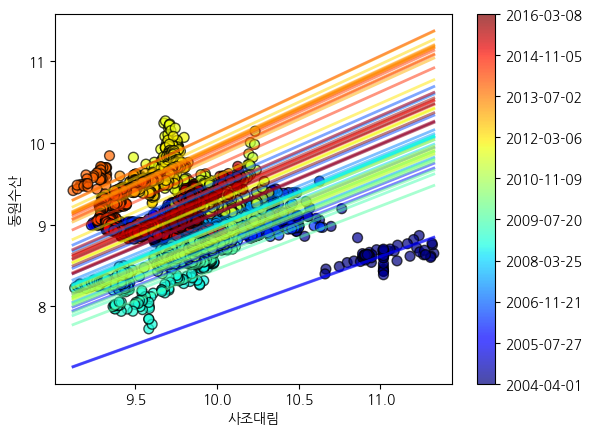

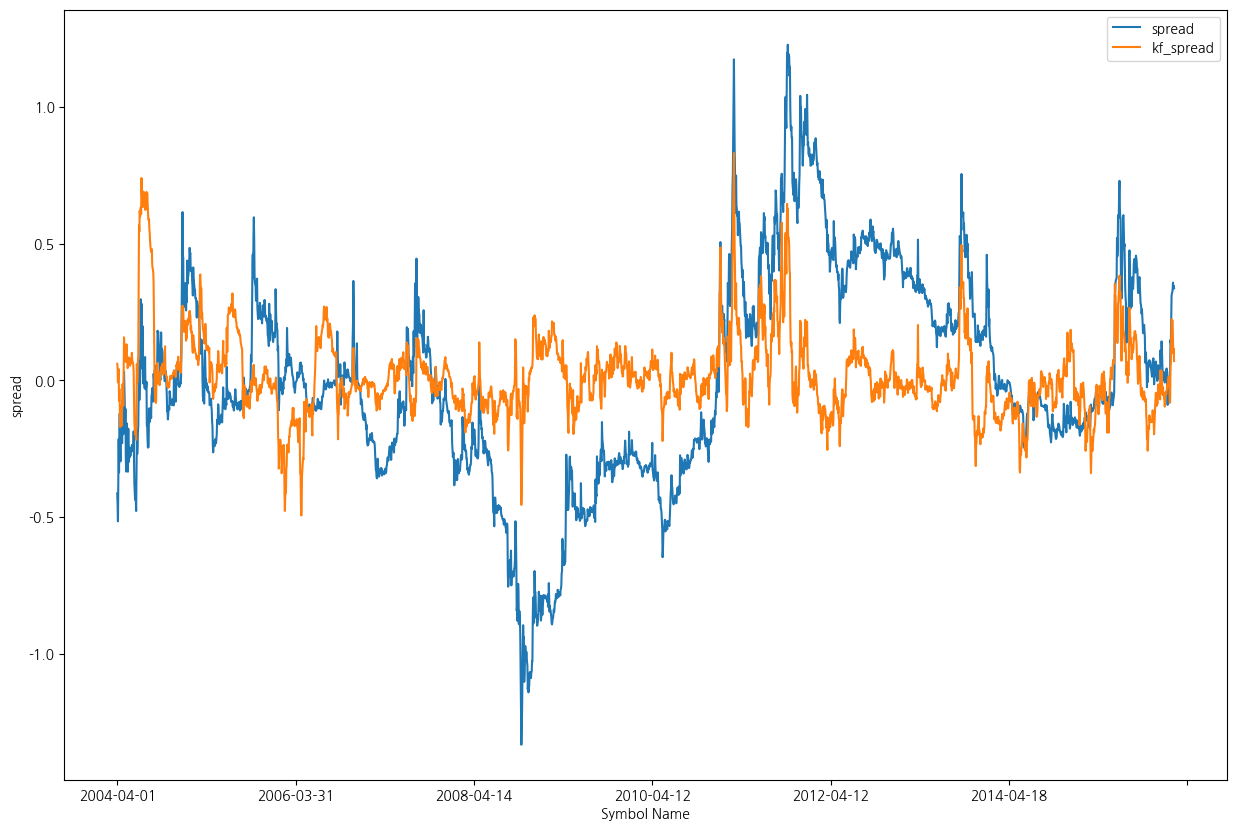

In [37]:
def kalman_graph(selected_results, df):
    stat_all = []; spread_all=[]
    for i in range(len(selected_results)):
        tickers = selected_results[i]['columns']
        obs_mat = sm.add_constant(np.log(df[tickers[0]].values), prepend=False)[:, np.newaxis]
        delta = 1e-5
        trans_cov = delta / (1 - delta) * np.eye(2)

        # y is 1-dimensional, (alpha, beta) is 2-dimensional
        kf = KalmanFilter(n_dim_obs=1, n_dim_state=2,
                        initial_state_mean=np.zeros(2),
                        initial_state_covariance=np.ones((2, 2)),
                        transition_matrices=np.eye(2),
                        observation_matrices=obs_mat,
                        observation_covariance=1.0,
                        transition_covariance=trans_cov)

        state_means, state_covs = kf.filter(np.log(df[tickers[1]]))
        beta_kf = pd.DataFrame(state_means, columns=['slope', 'intercept'])  # 회귀 계수 저장
        beta_kf.plot(subplots=True) 
        plt.show()

        # visualize the correlation between assest prices over time
        dates = [p for p in df[::int(len(df)/10)].index] # str(p.date())
        colors = np.linspace(0.1, 1, len(df))
        sc = plt.scatter(np.log(df[tickers[0]]), np.log(df[tickers[1]]),
                        s=50, c=colors, cmap=plt.get_cmap('jet'), edgecolor='k', alpha=0.7)
        cb = plt.colorbar(sc)
        cb.ax.set_yticklabels([p for p in df[::len(df)//9].index]); # [str(p.date())
        plt.xlabel(tickers[0])
        plt.ylabel(tickers[1])

        # add regression lines
        step = 50
        xi = np.linspace(np.log(df[tickers[0]].min()), np.log(df[tickers[0]].max()), 2)
        colors_l = np.linspace(0.1, 1, len(state_means[::step]))
        for i, b in enumerate(state_means[::step]):
            plt.plot(xi, b[0] * xi + b[1], alpha=.5, lw=2, c=plt.get_cmap('jet')(colors_l[i]))
        plt.show()

        x = list(np.log(df[tickers[0]]))
        x_const = sm.add_constant(x)
        y = list(np.log(df[tickers[1]]))
        linear_reg = sm.OLS(y,x_const)
        results = linear_reg.fit()
        beta = results.params[1]
        alpha = results.params[0]
        y_pred = np.log(df[tickers[0]])*beta + alpha

        df2 = pd.DataFrame(np.log(df[tickers[1]]) - np.log(df[tickers[0]])*beta-alpha,index=df[tickers[0]].index)
        df2.columns = ['spread']
        df2.plot(figsize =(15,10))   


        beta_kf.index = df.index
        spread_kf = np.log(df[tickers[1]]) - np.log(df[tickers[0]]) * beta_kf['slope'] - beta_kf['intercept']
        spread_all.append([spread_kf])
        spread_kf.plot(label = 'kf_spread')
        
        stat_all.append([tickers,state_means,state_covs])

        plt.ylabel('spread') 
        plt.legend()
        plt.show()
        
    return stat_all, spread_all

stat_all, spread_all = kalman_graph(selected_results, df)

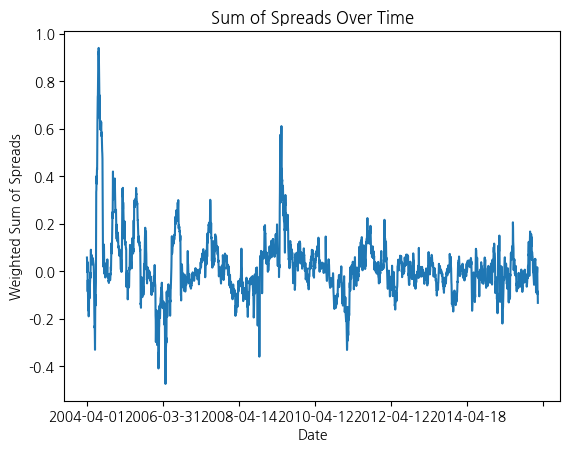

In [38]:
def get_spread(selected_results, spread_all):
    total_inverse_p_value = sum(1 / item['p_value'] for item in selected_results)
    for item in selected_results:
        item['ratio'] = (1 / item['p_value']) / total_inverse_p_value
    ratios = np.array([item['ratio'] for item in selected_results])  # 이제 numpy 배열로 변환하여 문제 해결 시도
    spread_series = [pd.Series(spread) for spread in spread_all]
    weighted_spreads = [spread_series[i][0] * ratios[i] for i in range(len(spread_series))]
    weighted_sum_spreads = pd.concat(weighted_spreads, axis=1).sum(axis=1)
    weighted_sum_spreads_series = pd.Series(weighted_sum_spreads)
    weighted_sum_spreads_series.plot()
    plt.title('Sum of Spreads Over Time')
    plt.xlabel('Date')
    plt.ylabel('Weighted Sum of Spreads')
    plt.show()
    return weighted_sum_spreads_series
weighted_sum_spreads_series = get_spread(selected_results, spread_all)

In [39]:
def adftest(data):
    #adf 검정!
    result = adfuller(data)

    print('정상성이 있는지 판단 : ')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    return key

def ARIMA_model(data):
    #델타yt의 경우와 그냥 yt의 경우에 감마의 값에 따라 평균회귀 가능성이 어떻게 달라지는지 조심하세요
    model = ARIMA(data, order=(1, 0, 0))
    model_fit = model.fit()
    print(f'λ 값의 유도(델타yt가 아닌 그냥 yt임 주의!!) : { model_fit.params[1] }')
    half = -np.log(2)/(model_fit.params[1]-1)
    print(f'반감기 : {half}')

    display(model_fit.summary())
    return half

def RS_func(data):
    L = np.log10(data[1:].values / data[:-1].values)
    nan_inf_indices = np.isnan(L) | np.isinf(L)
    L = L[~nan_inf_indices]
    Z = np.mean(L)
    C = np.cumsum(L-Z)
    R = max(C) - min(C)
    S = np.std(L)
    return R/S

def hurst_func(data):
    min_window = 10
    max_window = len(data) - 1
    by_factor = np.log10(2.0)
    window_sizes = list(map(lambda x: int(10 ** x),np.arange(np.log10(min_window), np.log10(max_window), by_factor)))
    window_sizes.append(len(data))

    RS = []
    for w in window_sizes:
        rs = []
        for start in range(0, len(data), w):
            if (start + w) > len(data):
                break
            res = RS_func(data[start:start + w].astype(np.float64))
            if res != 0:
                rs.append(res)
        RS.append(np.mean(rs))

    lm1 = LinearRegression().fit(np.log10(window_sizes).reshape(-1, 1),np.log10(RS).reshape(-1, 1))
    hurst_exp = lm1.coef_[0][0]
    print(f'H = {hurst_exp}')
    return hurst_exp
key = adftest(weighted_sum_spreads_series)
half=ARIMA_model(weighted_sum_spreads_series)
H = hurst_func(weighted_sum_spreads_series)

정상성이 있는지 판단 : 
ADF Statistic: -7.227200
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
λ 값의 유도(델타yt가 아닌 그냥 yt임 주의!!) : 0.9718206748276907
반감기 : 24.59772107108777


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2964
Model:                 ARIMA(1, 0, 0)   Log Likelihood                6138.775
Date:                Mon, 20 May 2024   AIC                         -12271.551
Time:                        06:10:11   BIC                         -12253.568
Sample:                             0   HQIC                        -12265.078
                               - 2964                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0198      0.020      0.980      0.327      -0.020       0.059
ar.L1          0.9718      0.003    370.001      0.000       0.967       0.977
sigma2         0.0009   1.22e-05     75.935      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                  10.59   Jarque-Bera (JB):              4258.38
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.57   Skew:                             0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

H = 0.4602289328562025


C:\Users\user\AppData\Local\Temp\ipykernel_17492\1511956018.py:25: RuntimeWarning: invalid value encountered in log10
  L = np.log10(data[1:].values / data[:-1].values)
C:\Users\user\AppData\Local\Temp\ipykernel_17492\1511956018.py:25: RuntimeWarning: invalid value encountered in log10
  L = np.log10(data[1:].values / data[:-1].values)
C:\Users\user\AppData\Local\Temp\ipykernel_17492\1511956018.py:25: RuntimeWarning: invalid value encountered in log10
  L = np.log10(data[1:].values / data[:-1].values)
C:\Users\user\AppData\Local\Temp\ipykernel_17492\1511956018.py:25: RuntimeWarning: invalid value encountered in log10
  L = np.log10(data[1:].values / data[:-1].values)
C:\Users\user\AppData\Local\Temp\ipykernel_17492\1511956018.py:25: RuntimeWarning: invalid value encountered in log10
  L = np.log10(data[1:].values / data[:-1].values)
C:\Users\user\AppData\Local\Temp\ipykernel_17492\1511956018.py:25: RuntimeWarning: invalid value encountered in log10
  L = np.log10(data[1:].values / data

In [40]:
mean_spread = weighted_sum_spreads_series.mean()
std_spread = weighted_sum_spreads_series.std()
upper_bound = mean_spread + 2 * std_spread
upper_stop_bound = mean_spread + 3 * std_spread
lower_bound = mean_spread - 2 * std_spread
lowwer_stop_bound = mean_spread - 3 * std_spread
close_range = std_spread * 0.1
print(upper_bound,upper_stop_bound,lower_bound,lowwer_stop_bound)

0.27752496626623013 0.4063868956383154 -0.23792275122211104 -0.36678468059419633


In [41]:
df = test_data[groups[algorithm][test_num]]

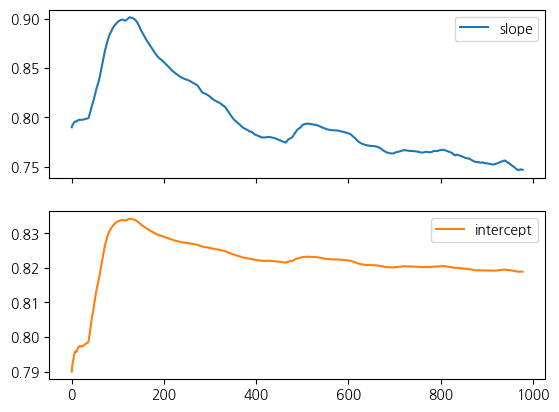

C:\Users\user\AppData\Local\Temp\ipykernel_17492\282360678.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels([p for p in df[::len(df)//9].index]); # [str(p.date())


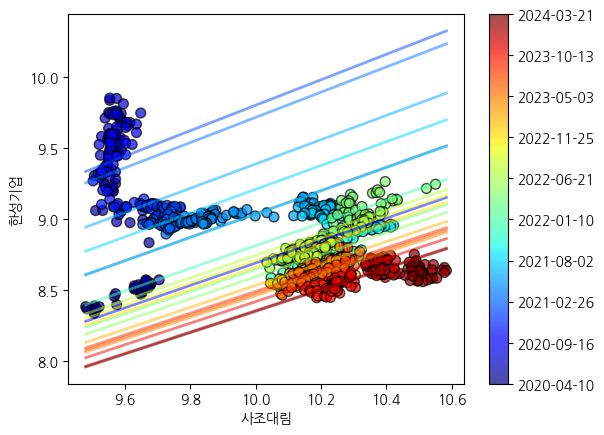

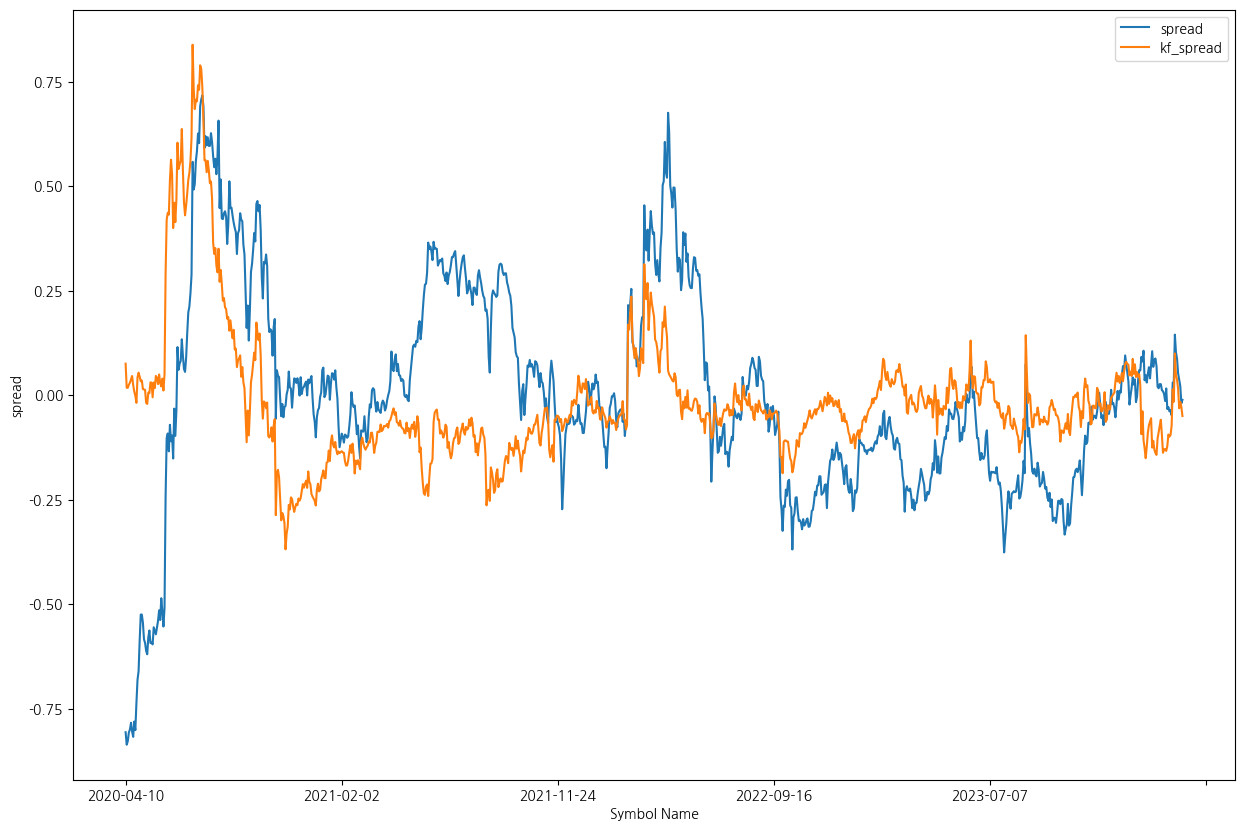

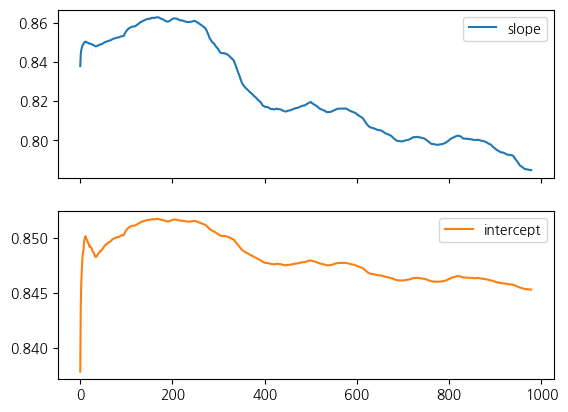

C:\Users\user\AppData\Local\Temp\ipykernel_17492\282360678.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels([p for p in df[::len(df)//9].index]); # [str(p.date())


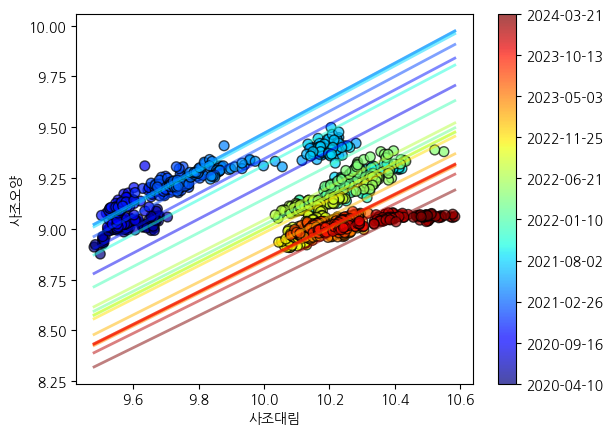

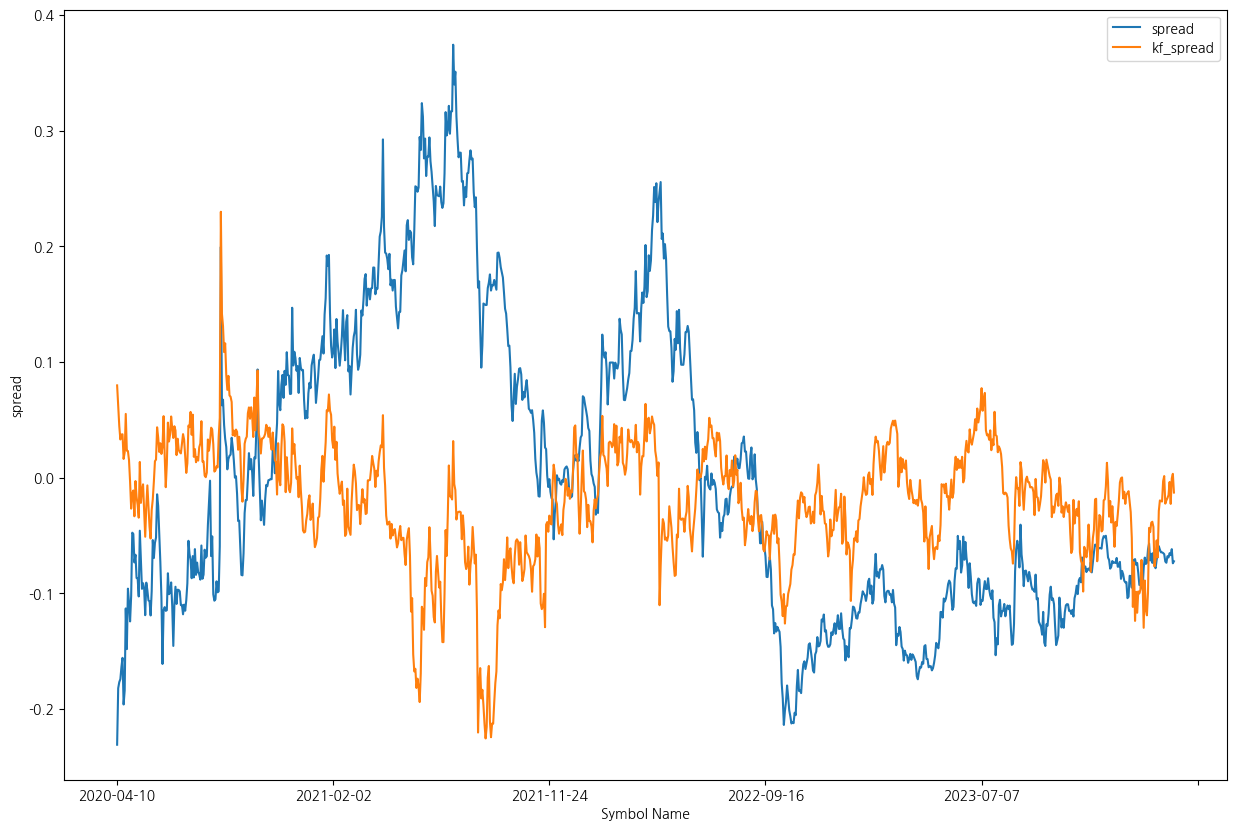

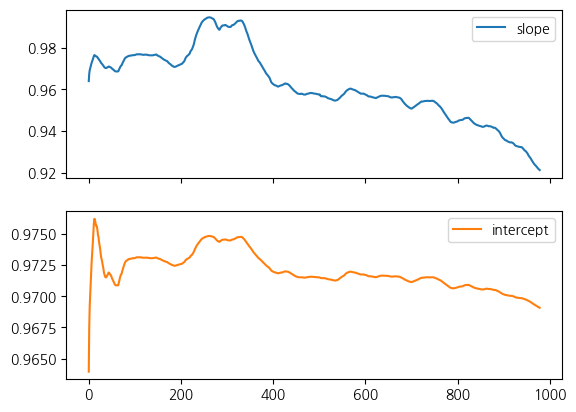

C:\Users\user\AppData\Local\Temp\ipykernel_17492\282360678.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels([p for p in df[::len(df)//9].index]); # [str(p.date())


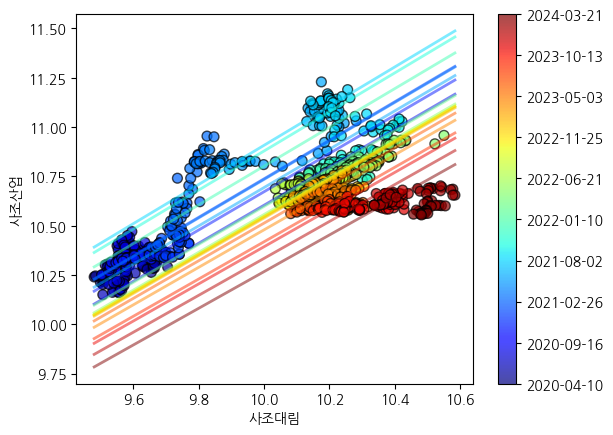

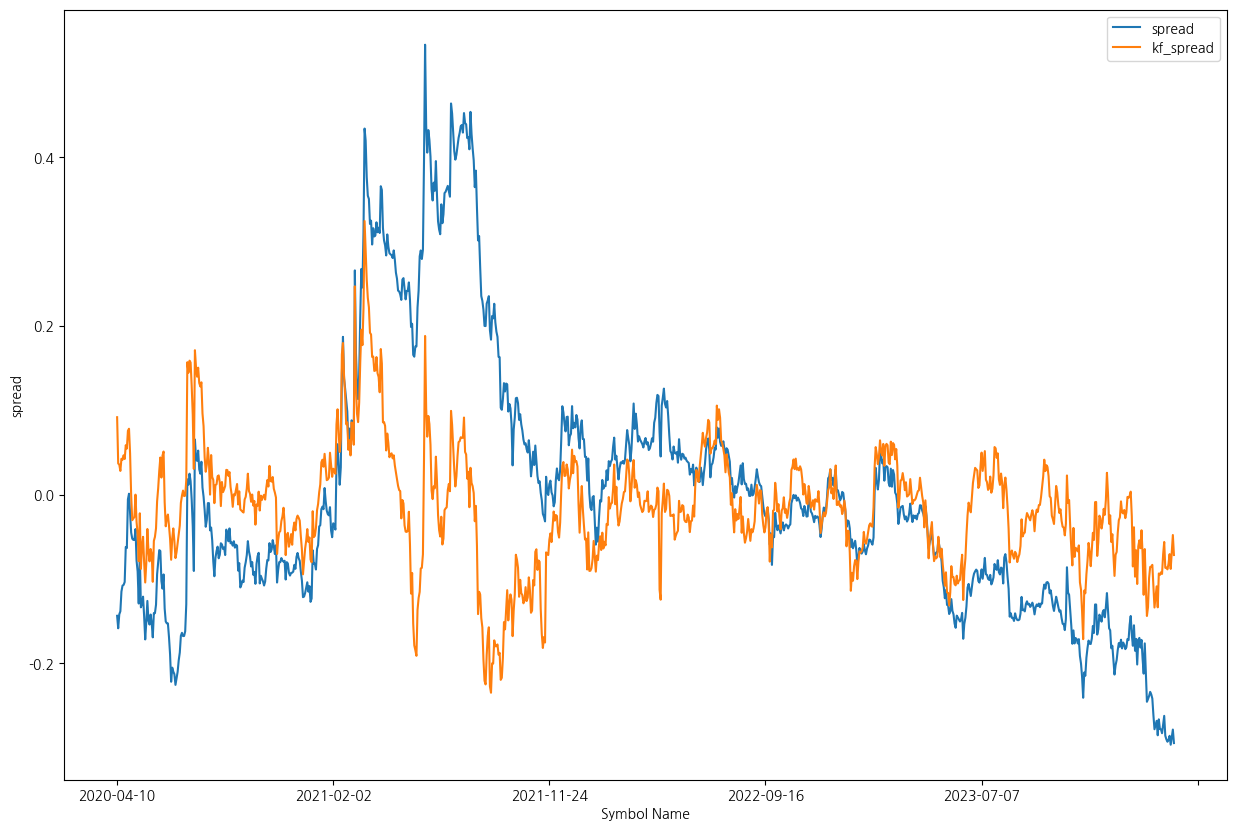

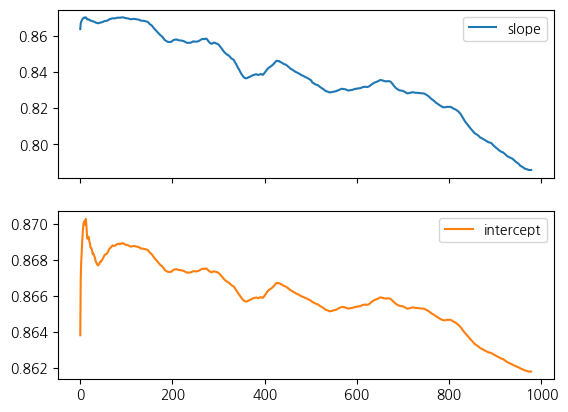

C:\Users\user\AppData\Local\Temp\ipykernel_17492\282360678.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels([p for p in df[::len(df)//9].index]); # [str(p.date())


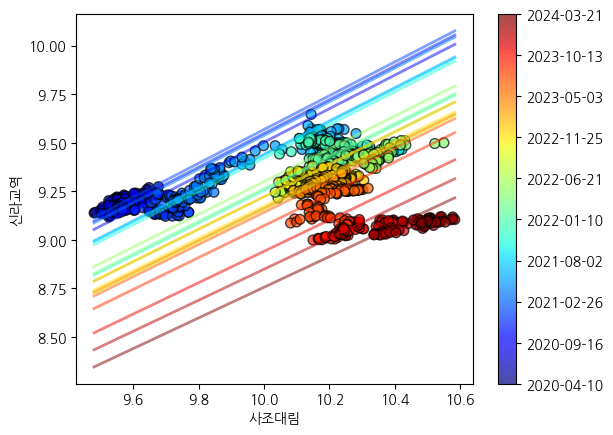

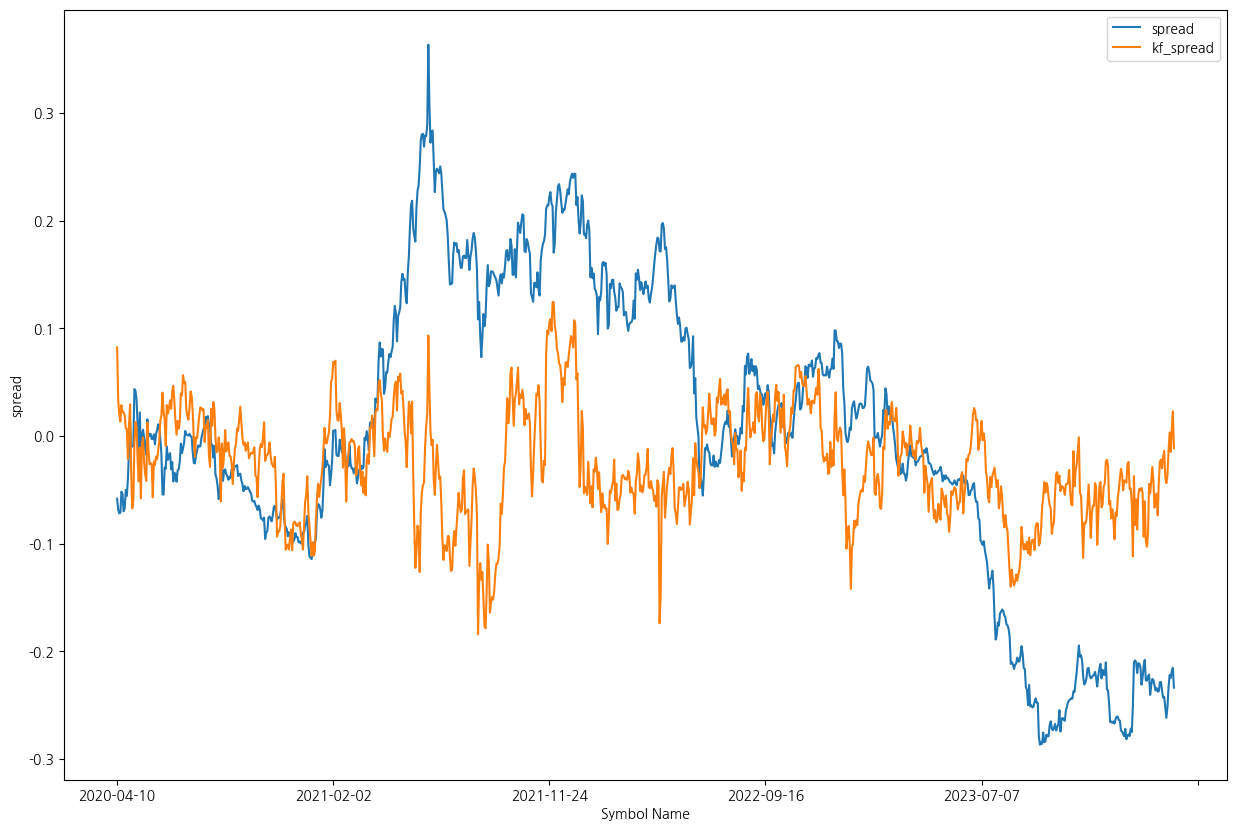

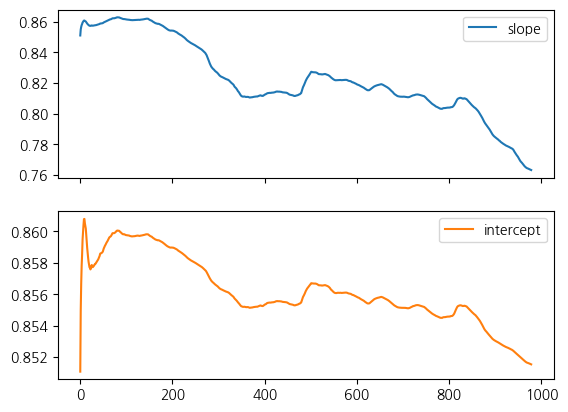

C:\Users\user\AppData\Local\Temp\ipykernel_17492\282360678.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels([p for p in df[::len(df)//9].index]); # [str(p.date())


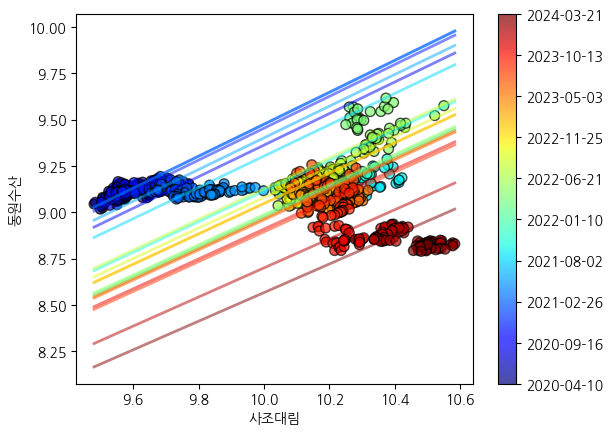

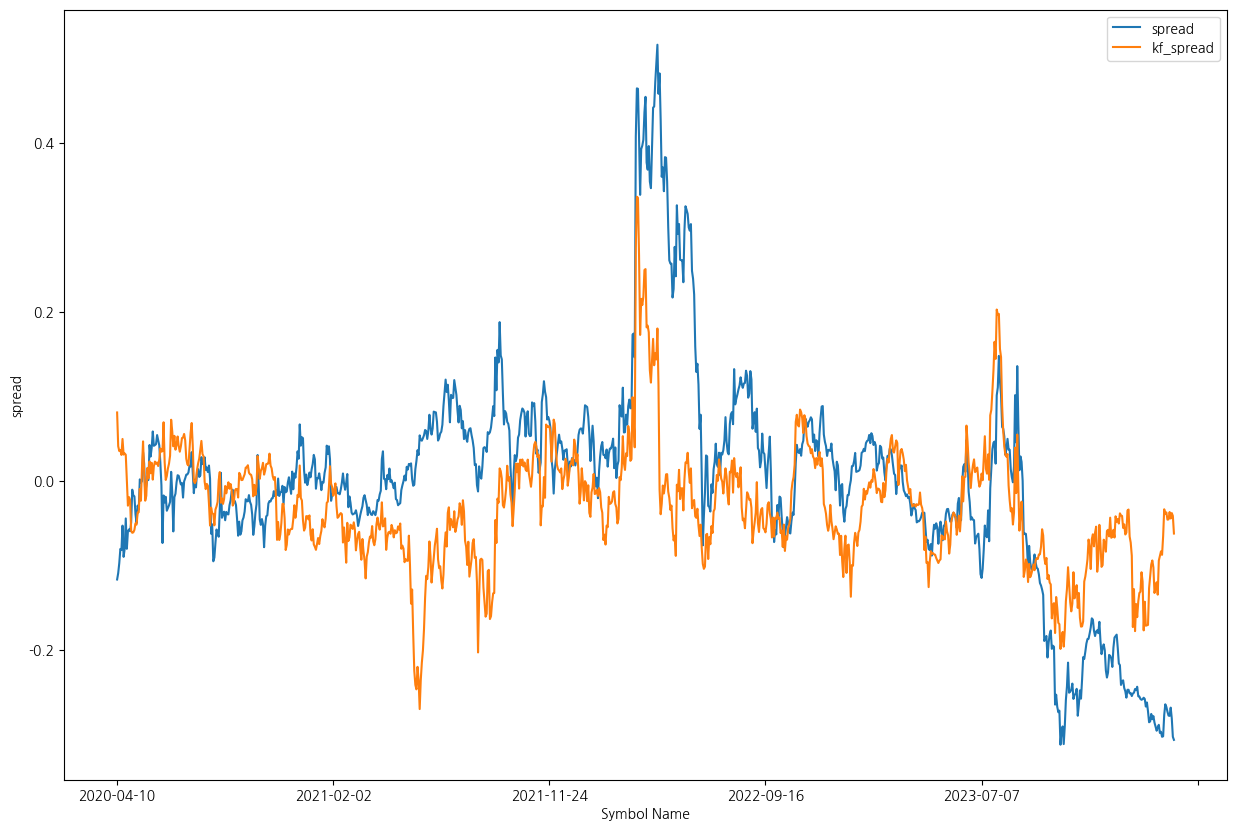

In [42]:
stat_all, spread_all = kalman_graph(selected_results, df)

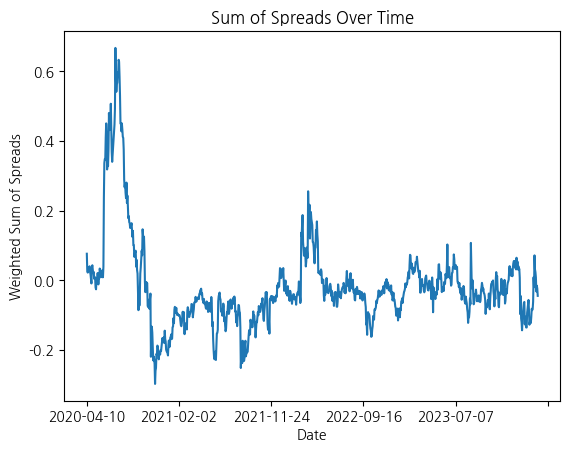

In [43]:
weighted_sum_spreads_series = get_spread(selected_results, spread_all)

In [44]:
# 상태 플래그
def get_signal(weighted_sum_spreads_series,mean_spread, close_range, upper_stop_bound, lowwer_stop_bound,half,Asset1,Asset2):
    above = False
    below = False
    keep = False
    signals = []
    startday=0

    for date, value in weighted_sum_spreads_series.items():
        day = weighted_sum_spreads_series.index.get_loc(date)
        if value > upper_bound:
            above = True
        elif value < lower_bound:
            below = True
        elif keep and ((mean_spread - close_range <= value <= mean_spread + close_range) or value > upper_stop_bound or value < lowwer_stop_bound or day - startday > half):
            for index, result in enumerate(selected_results):
                asset1_name = result['columns'][0]
                asset2_name = result['columns'][1]
                if asset1_name in Asset1 and asset2_name in Asset2:
                    signals.append({
                        'Date': date,
                        'asset1': asset1_name,
                        'asset2': asset2_name,
                        'Investment Amount': result['ratio'],
                        'Investment Type': 'Close'
                    })
                else:
                    signals.append({
                        'Date': date,
                        'asset1': asset2_name,
                        'asset2': asset1_name,
                        'Investment Amount': result['ratio'],
                        'Investment Type': 'Close'
                    })
            keep = False
            below = False
            above = False
        elif (keep == 0) and above and value <= upper_bound:
            for index, result in enumerate(selected_results):
                asset1_name = result['columns'][0]
                asset2_name = result['columns'][1]
                if asset1_name in Asset1 and asset2_name in Asset2:
                    signals.append({
                        'Date': date,
                        'asset1': asset1_name,
                        'asset2': asset2_name,
                        'Investment Amount': result['ratio'],
                        'Investment Type': 'Long'
                    })
                else:
                    signals.append({
                        'Date': date,
                        'asset1': asset2_name,
                        'asset2': asset1_name,
                        'Investment Amount': result['ratio'],
                        'Investment Type': 'Short'
                    })
            above = False
            keep = True
            startday = weighted_sum_spreads_series.index.get_loc(date)
        elif (keep == 0) and below and value >= lower_bound:
            for index, result in enumerate(selected_results):
                asset1_name = result['columns'][0]
                asset2_name = result['columns'][1]
                if asset1_name in Asset1 and asset2_name in Asset2:
                    signals.append({
                        'Date': date,
                        'asset1': asset1_name,
                        'asset2': asset2_name,
                        'Investment Amount': result['ratio'],
                        'Investment Type': 'Short'
                    })
                else:
                    signals.append({
                        'Date': date,
                        'asset1': asset2_name,
                        'asset2': asset1_name,
                        'Investment Amount': result['ratio'],
                        'Investment Type': 'Long'
                    })
            below = False
            keep = True
            startday = weighted_sum_spreads_series.index.get_loc(date)

    # 데이터프레임으로 변환
    signals_df = pd.DataFrame(signals)
    return signals_df
signals_df = get_signal(weighted_sum_spreads_series,mean_spread, close_range, upper_stop_bound, lowwer_stop_bound,half,Asset1,Asset2)
signals_df

Date asset1 asset2  Investment Amount Investment Type
0   2020-08-10   사조대림   한성기업           0.789113            Long
1   2020-08-10   사조대림   사조오양           0.161787            Long
2   2020-08-10   사조대림   사조산업           0.032542            Long
3   2020-08-10   사조대림   신라교역           0.011532            Long
4   2020-08-10   사조대림   동원수산           0.005026            Long
5   2020-09-15   사조대림   한성기업           0.789113           Close
6   2020-09-15   사조대림   사조오양           0.161787           Close
7   2020-09-15   사조대림   사조산업           0.032542           Close
8   2020-09-15   사조대림   신라교역           0.011532           Close
9   2020-09-15   사조대림   동원수산           0.005026           Close
10  2020-11-20   사조대림   한성기업           0.789113           Short
11  2020-11-20   사조대림   사조오양           0.161787           Short
12  2020-11-20   사조대림   사조산업           0.032542           Short
13  2020-11-20   사조대림   신라교역           0.011532           Short
14  2020-11-20   사조대림   동원수산           0.005026           Short
15  2020-12-28   사조대림   한성기업           0.789113           Close
16  2020-12-28   사조대림   사조오양           0.161787           Close
17  2020-12-28   사조대림   사조산업           0.032542           Close
18  2020-12-28   사조대림   신라교역           0.011532           Close
19  2020-12-28   사조대림   동원수산           0.005026           Close
20  2021-08-18   사조대림   한성기업           0.789113           Short
21  2021-08-18   사조대림   사조오양           0.161787           Short
22  2021-08-18   사조대림   사조산업           0.032542           Short
23  2021-08-18   사조대림   신라교역           0.011532           Short
24  2021-08-18   사조대림   동원수산           0.005026           Short
25  2021-09-27   사조대림   한성기업           0.789113           Close
26  2021-09-27   사조대림   사조오양           0.161787           Close
27  2021-09-27   사조대림   사조산업           0.032542           Close
28  2021-09-27   사조대림   신라교역           0.011532           Close
29  2021-09-27   사조대림   동원수산           0.005026           Close

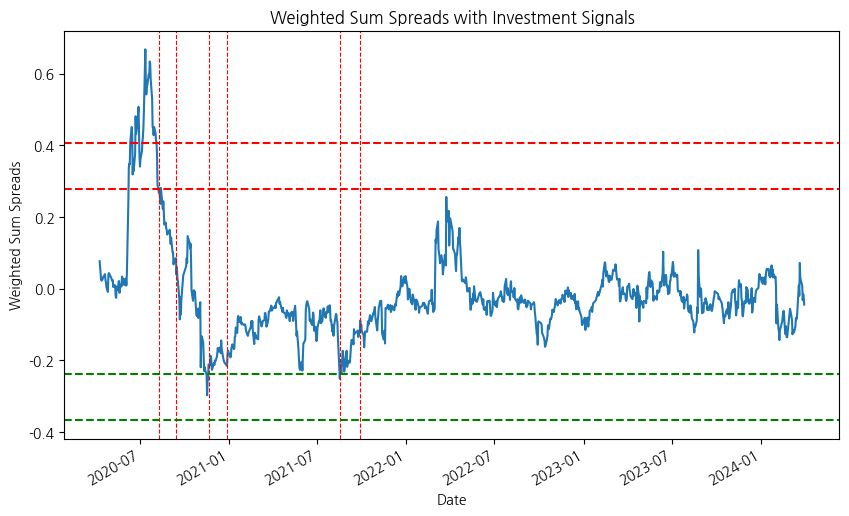

In [45]:
import matplotlib.pyplot as plt
def spread_graph(weighted_sum_spreads_series, signals_df):
    # 데이터 타입을 datetime으로 변환 (필요한 경우)
    signals_df['Date'] = pd.to_datetime(signals_df['Date'])
    weighted_sum_spreads_series.index = pd.to_datetime(weighted_sum_spreads_series.index)

    # weighted_sum_spreads_series 그래프 그리기
    plt.figure(figsize=(10, 6))
    weighted_sum_spreads_series.plot()

    # signals_df에서 중복 없이 모든 날짜 가져오기
    unique_dates = signals_df['Date'].drop_duplicates()

    # 각 날짜에 대해 수직선 그리기
    for date in unique_dates:
        plt.axvline(x=date, color='r', linestyle='--', linewidth=0.8)

    # 그래프에 타이틀 및 레이블 추가
    plt.title('Weighted Sum Spreads with Investment Signals')
    plt.xlabel('Date')
    plt.ylabel('Weighted Sum Spreads')
    plt.axhline(y=upper_bound, color='r', linestyle='--', label='Upper Bound (2 Std Dev)')
    plt.axhline(y=upper_stop_bound, color='r', linestyle='--', label='Upper Bound (2 Std Dev)')
    plt.axhline(y=lower_bound, color='g', linestyle='--', label='Lower Bound (2 Std Dev)')
    plt.axhline(y=lowwer_stop_bound, color='g', linestyle='--', label='Lower Bound (2 Std Dev)')

    # 그래프 보여주기
    plt.show()

spread_graph(weighted_sum_spreads_series, signals_df)

In [46]:
signals_df

Date asset1 asset2  Investment Amount Investment Type
0  2020-08-10   사조대림   한성기업           0.789113            Long
1  2020-08-10   사조대림   사조오양           0.161787            Long
2  2020-08-10   사조대림   사조산업           0.032542            Long
3  2020-08-10   사조대림   신라교역           0.011532            Long
4  2020-08-10   사조대림   동원수산           0.005026            Long
5  2020-09-15   사조대림   한성기업           0.789113           Close
6  2020-09-15   사조대림   사조오양           0.161787           Close
7  2020-09-15   사조대림   사조산업           0.032542           Close
8  2020-09-15   사조대림   신라교역           0.011532           Close
9  2020-09-15   사조대림   동원수산           0.005026           Close
10 2020-11-20   사조대림   한성기업           0.789113           Short
11 2020-11-20   사조대림   사조오양           0.161787           Short
12 2020-11-20   사조대림   사조산업           0.032542           Short
13 2020-11-20   사조대림   신라교역           0.011532           Short
14 2020-11-20   사조대림   동원수산           0.005026           Short
15 2020-12-28   사조대림   한성기업           0.789113           Close
16 2020-12-28   사조대림   사조오양           0.161787           Close
17 2020-12-28   사조대림   사조산업           0.032542           Close
18 2020-12-28   사조대림   신라교역           0.011532           Close
19 2020-12-28   사조대림   동원수산           0.005026           Close
20 2021-08-18   사조대림   한성기업           0.789113           Short
21 2021-08-18   사조대림   사조오양           0.161787           Short
22 2021-08-18   사조대림   사조산업           0.032542           Short
23 2021-08-18   사조대림   신라교역           0.011532           Short
24 2021-08-18   사조대림   동원수산           0.005026           Short
25 2021-09-27   사조대림   한성기업           0.789113           Close
26 2021-09-27   사조대림   사조오양           0.161787           Close
27 2021-09-27   사조대림   사조산업           0.032542           Close
28 2021-09-27   사조대림   신라교역           0.011532           Close
29 2021-09-27   사조대림   동원수산           0.005026           Close

In [47]:
corrected_results = []
for item in selected_results:
    current_columns = item['columns']
    if current_columns[0] in Asset2 and current_columns[1] in Asset1:
        corrected_columns = [current_columns[1], current_columns[0]]
    else:
        corrected_columns = current_columns
    corrected_item = item.copy()
    corrected_item['columns'] = corrected_columns
    corrected_results.append(corrected_item)
for result in corrected_results:
    print(result)
selected_results = corrected_results

{'columns': ['사조대림', '한성기업'], 'adf_statistic': -5.25352319358917, 'p_value': 6.82950640204559e-06, 'critical_values': {'1%': -3.4325754392267975, '5%': -2.862523252048813, '10%': -2.567293412144613}, 'ratio': 0.7891126616136125}
{'columns': ['사조대림', '사조오양'], 'adf_statistic': -4.910225484991651, 'p_value': 3.3310807449201134e-05, 'critical_values': {'1%': -3.432577713619062, '5%': -2.8625242565537934, '10%': -2.567293946934166}, 'ratio': 0.16178683097502183}
{'columns': ['사조대림', '사조산업'], 'adf_statistic': -4.541110544744947, 'p_value': 0.00016560733169753748, 'critical_values': {'1%': -3.4325761968413655, '5%': -2.862523586655913, '10%': -2.5672935902864547}, 'ratio': 0.03254233927437609}
{'columns': ['사조대림', '신라교역'], 'adf_statistic': -4.287254222449346, 'p_value': 0.000467337928278817, 'critical_values': {'1%': -3.4325754392267975, '5%': -2.862523252048813, '10%': -2.567293412144613}, 'ratio': 0.011531805249091913}
{'columns': ['사조대림', '동원수산'], 'adf_statistic': -4.073193776026631, 'p_va

In [48]:

initial_capital = 100000000  # 1억

# 자본 변동을 추적할 DataFrame 준비
capital_df = pd.DataFrame(index=df.index)
capital_df['capital'] = initial_capital
signals_df['Date'] = signals_df['Date'].astype(str)
# 포지션을 추적할 딕셔너리
position_all = []

# 각 신호를 처리
for index, signal in signals_df.iterrows():
    date = signal['Date']
    asset1 = signal['asset1']
    asset2 = signal['asset2']
    investment_ratio = signal['Investment Amount']
    trade_type = signal['Investment Type']

    pair_index = [i for i, pairs in enumerate(selected_results) if pairs['columns'] == [asset1, asset2]][0]

    # 자본에서 투자할 금액 계산
    investment_amount = initial_capital * investment_ratio
    hedge_ratios = pd.Series(stat_all[pair_index][1][:, 0], index=pd.Series(spread_all[pair_index][0]).index)
    # 헷지 비율에 따른 투자 금액 계산

    if date in pd.Series(spread_all[pair_index][0]).index:
        hedge_ratio = 1
        amount_asset1 = investment_amount / (1 + hedge_ratio)
        amount_asset2 = amount_asset1 * hedge_ratio
    else:
        continue  # 해당 날짜에 헷지 비율 데이터가 없으면 거래를 진행하지 않음
    
    # 가격 정보
    price_asset1 = df.loc[date, asset1]
    price_asset2 = df.loc[date, asset2]
    
    # 거래 수량 계산
    quantity_asset1 = amount_asset1 / price_asset1
    quantity_asset2 = amount_asset2 / price_asset2
    positions = {}
    if trade_type == 'Long':
        # Asset1을 매수하고 Asset2를 매도
        positions[date] = {'asset1': (asset1, quantity_asset1, price_asset1,amount_asset1, 'buy'),
                           'asset2': (asset2, quantity_asset2, price_asset2,amount_asset2, 'sell')}
    elif trade_type == 'Short':
        # Asset1을 매도하고 Asset2를 매수
        positions[date] = {'asset1': (asset1, quantity_asset1, price_asset1, amount_asset1,'sell'),
                           'asset2': (asset2, quantity_asset2, price_asset2, amount_asset2,'buy')}
    elif trade_type == 'Close':
        positions[date] = {'asset1': (asset1, quantity_asset1, price_asset1,amount_asset1, 'close'),
                    'asset2': (asset2, quantity_asset2, price_asset2, amount_asset2,'close')}
    position_all.append(positions)

In [49]:
selected_results

[{'columns': ['사조대림', '한성기업'],
  'adf_statistic': -5.25352319358917,
  'p_value': 6.82950640204559e-06,
  'critical_values': {'1%': -3.4325754392267975,
   '5%': -2.862523252048813,
   '10%': -2.567293412144613},
  'ratio': 0.7891126616136125},
 {'columns': ['사조대림', '사조오양'],
  'adf_statistic': -4.910225484991651,
  'p_value': 3.3310807449201134e-05,
  'critical_values': {'1%': -3.432577713619062,
   '5%': -2.8625242565537934,
   '10%': -2.567293946934166},
  'ratio': 0.16178683097502183},
 {'columns': ['사조대림', '사조산업'],
  'adf_statistic': -4.541110544744947,
  'p_value': 0.00016560733169753748,
  'critical_values': {'1%': -3.4325761968413655,
   '5%': -2.862523586655913,
   '10%': -2.5672935902864547},
  'ratio': 0.03254233927437609},
 {'columns': ['사조대림', '신라교역'],
  'adf_statistic': -4.287254222449346,
  'p_value': 0.000467337928278817,
  'critical_values': {'1%': -3.4325754392267975,
   '5%': -2.862523252048813,
   '10%': -2.567293412144613},
  'ratio': 0.011531805249091913},
 {'colum

In [50]:
# 데이터프레임으로 변환하기 위한 빈 리스트 생성
data = []

# 각 항목을 반복하면서 데이터 추출 및 정리
for entry in position_all:
    for date, assets in entry.items():
        asset1_data = {
            'date': date,
            'asset_name': assets['asset1'][0],
            'quantity': assets['asset1'][1],
            'price': assets['asset1'][2],
            'amount': assets['asset1'][3],
            'action': assets['asset1'][4],
            'asset_type': 'asset1'
        }
        asset2_data = {
            'date': date,
            'asset_name': assets['asset2'][0],
            'quantity': assets['asset2'][1],
            'price': assets['asset2'][2],
            'amount': assets['asset2'][3],
            'action': assets['asset2'][4],
            'asset_type': 'asset2'
        }
        data.append(asset1_data)
        data.append(asset2_data)

# 데이터 리스트를 데이터프레임으로 변환
position_df = pd.DataFrame(data)
position_df

date asset_name     quantity    price        amount action   
0   2020-08-10       사조대림  2648.029066  14900.0  3.945563e+07    buy  \
1   2020-08-10       한성기업  2521.126714  15650.0  3.945563e+07   sell   
2   2020-08-10       사조대림   542.908829  14900.0  8.089342e+06    buy   
3   2020-08-10       사조오양   958.452790   8440.0  8.089342e+06   sell   
4   2020-08-10       사조대림   109.202481  14900.0  1.627117e+06    buy   
5   2020-08-10       사조산업    50.847405  32000.0  1.627117e+06   sell   
6   2020-08-10       사조대림    38.697333  14900.0  5.765903e+05    buy   
7   2020-08-10       신라교역    55.979637  10300.0  5.765903e+05   sell   
8   2020-08-10       사조대림    16.866990  14900.0  2.513181e+05    buy   
9   2020-08-10       동원수산    26.907724   9340.0  2.513181e+05   sell   
10  2020-09-15       사조대림  2612.955833  15100.0  3.945563e+07  close   
11  2020-09-15       한성기업  2879.973218  13700.0  3.945563e+07  close   
12  2020-09-15       사조대림   535.717983  15100.0  8.089342e+06  close   
13  2020-09-15       사조오양   870.757971   9290.0  8.089342e+06  close   
14  2020-09-15       사조대림   107.756090  15100.0  1.627117e+06  close   
15  2020-09-15       사조산업    51.654507  31500.0  1.627117e+06  close   
16  2020-09-15       사조대림    38.184786  15100.0  5.765903e+05  close   
17  2020-09-15       신라교역    58.835741   9800.0  5.765903e+05  close   
18  2020-09-15       사조대림    16.643586  15100.0  2.513181e+05  close   
19  2020-09-15       동원수산    27.556814   9120.0  2.513181e+05  close   
20  2020-11-20       사조대림  2521.126714  15650.0  3.945563e+07   sell   
21  2020-11-20       한성기업  4228.899580   9330.0  3.945563e+07    buy   
22  2020-11-20       사조대림   516.890834  15650.0  8.089342e+06   sell   
23  2020-11-20       사조오양   842.639745   9600.0  8.089342e+06    buy   
24  2020-11-20       사조대림   103.969135  15650.0  1.627117e+06   sell   
25  2020-11-20       사조산업    51.736628  31450.0  1.627117e+06    buy   
26  2020-11-20       사조대림    36.842828  15650.0  5.765903e+05   sell   
27  2020-11-20       신라교역    61.014843   9450.0  5.765903e+05    buy   
28  2020-11-20       사조대림    16.058667  15650.0  2.513181e+05   sell   
29  2020-11-20       동원수산    27.678210   9080.0  2.513181e+05    buy   
30  2020-12-28       사조대림  2465.977068  16000.0  3.945563e+07  close   
31  2020-12-28       한성기업  5013.422247   7870.0  3.945563e+07  close   
32  2020-12-28       사조대림   505.583847  16000.0  8.089342e+06  close   
33  2020-12-28       사조오양   847.939366   9540.0  8.089342e+06  close   
34  2020-12-28       사조대림   101.694810  16000.0  1.627117e+06  close   
35  2020-12-28       사조산업    52.403123  31050.0  1.627117e+06  close   
36  2020-12-28       사조대림    36.036891  16000.0  5.765903e+05  close   
37  2020-12-28       신라교역    60.885983   9470.0  5.765903e+05  close   
38  2020-12-28       사조대림    15.707384  16000.0  2.513181e+05  close   
39  2020-12-28       동원수산    27.466464   9150.0  2.513181e+05  close   
40  2021-08-18       사조대림  1355.863680  29100.0  3.945563e+07   sell   
41  2021-08-18       한성기업  5331.842308   7400.0  3.945563e+07    buy   
42  2021-08-18       사조대림   277.984246  29100.0  8.089342e+06   sell   
43  2021-08-18       사조오양   742.141426  10900.0  8.089342e+06    buy   
44  2021-08-18       사조대림    55.914672  29100.0  1.627117e+06   sell   
45  2021-08-18       사조산업    25.745522  63200.0  1.627117e+06    buy   
46  2021-08-18       사조대림    19.814098  29100.0  5.765903e+05   sell   
47  2021-08-18       신라교역    46.687471  12350.0  5.765903e+05    buy   
48  2021-08-18       사조대림     8.636362  29100.0  2.513181e+05   sell   
49  2021-08-18       동원수산    27.496515   9140.0  2.513181e+05    buy   
50  2021-09-27       사조대림  1353.538013  29150.0  3.945563e+07  close   
51  2021-09-27       한성기업  5580.711893   7070.0  3.945563e+07  close   
52  2021-09-27       사조대림   277.507429  29150.0  8.089342e+06  close   
53  2021-09-27       사조오양   763.145429  10600.0  8.089342e+06  close   
54  2021-09-27       사조대림    55.818764  29150.0  1

# 거래시 수수료 1%

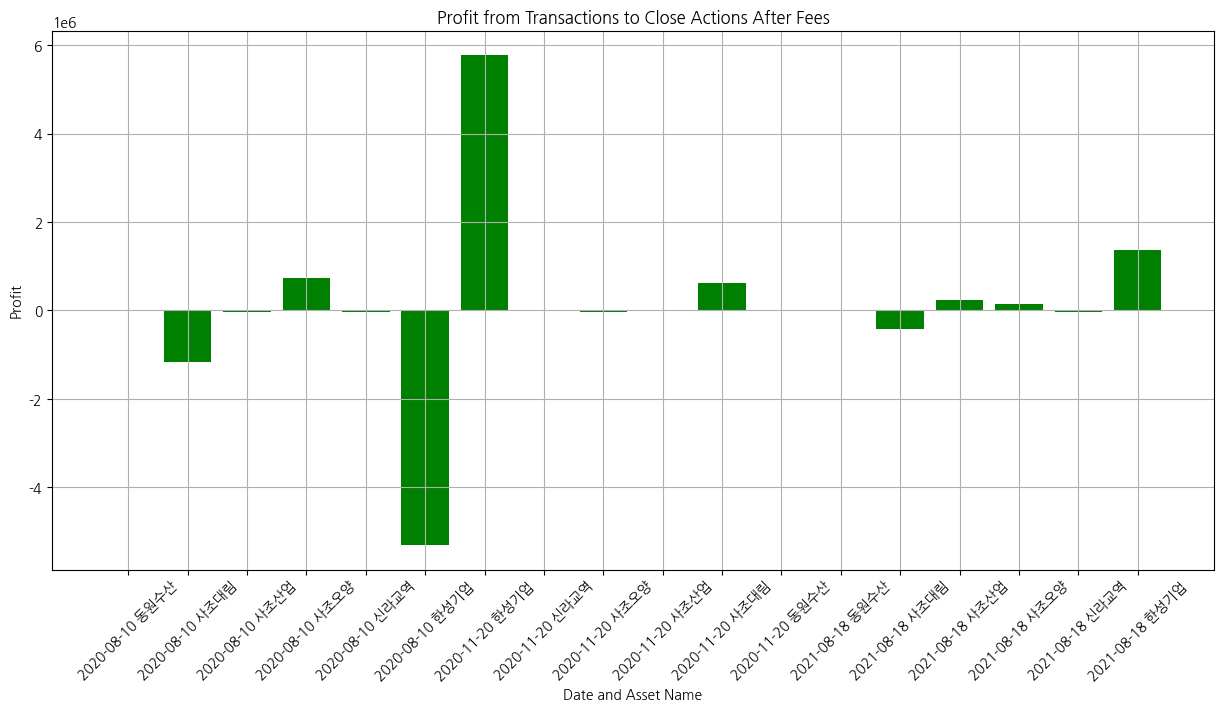

In [51]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 필터링
buy_short_df = position_df[(position_df['action'] == 'buy') | (position_df['action'] == 'sell')]
close_df = position_df[position_df['action'] == 'close']

# 'buy' 및 'short' 데이터에 대한 집계
buy_short_agg = buy_short_df.groupby(['date', 'asset_name', 'action']).agg({
    'quantity': 'sum',  # 총 수량 합계
    'price': 'mean'     # 평균 가격
}).reset_index()

close_agg = close_df.groupby(['date', 'asset_name']).agg({
    'quantity': 'sum',  # 총 수량 합계
    'price': 'mean'     # 평균 가격
}).reset_index()

# 날짜 데이터 타입을 보장하기 위해 변환
buy_short_agg['date'] = pd.to_datetime(buy_short_agg['date'])
close_agg['date'] = pd.to_datetime(close_agg['date'])

# 날짜에 따라 정렬 (merge_asof의 요구사항)
buy_short_agg.sort_values('date', inplace=True)
close_agg.sort_values('date', inplace=True)

# buy_short_agg의 각 행에 대해 date_close 컬럼이 date_trade 이후 가장 가까운 날짜를 갖는 행을 찾아 매칭
matched_df = pd.merge_asof(buy_short_agg, close_agg, on='date', by='asset_name', suffixes=('_trade', '_close'), direction='forward')

# 수익 계산 전, 거래 비용 1% 고려
matched_df['fee'] = matched_df['quantity_trade'] * matched_df['price_trade'] * 0.01  # 수수료 계산

# 수익 계산 (거래시 수수료 반영)
matched_df['profit'] = matched_df.apply(
    lambda row: row['quantity_trade'] * (row['price_trade'] - row['price_close']) - row['fee'] if row['action'] == 'buy'
    else row['quantity_trade'] * (row['price_close'] - row['price_trade']) - row['fee'],
    axis=1
)

# 수익 그래프 그리기
plt.figure(figsize=(15, 7))
plt.bar(matched_df['date'].astype(str) + ' ' + matched_df['asset_name'], matched_df['profit'], color='green')
plt.xticks(rotation=45)
plt.title('Profit from Transactions to Close Actions After Fees')
plt.xlabel('Date and Asset Name')
plt.ylabel('Profit')
plt.grid(True)
plt.show()


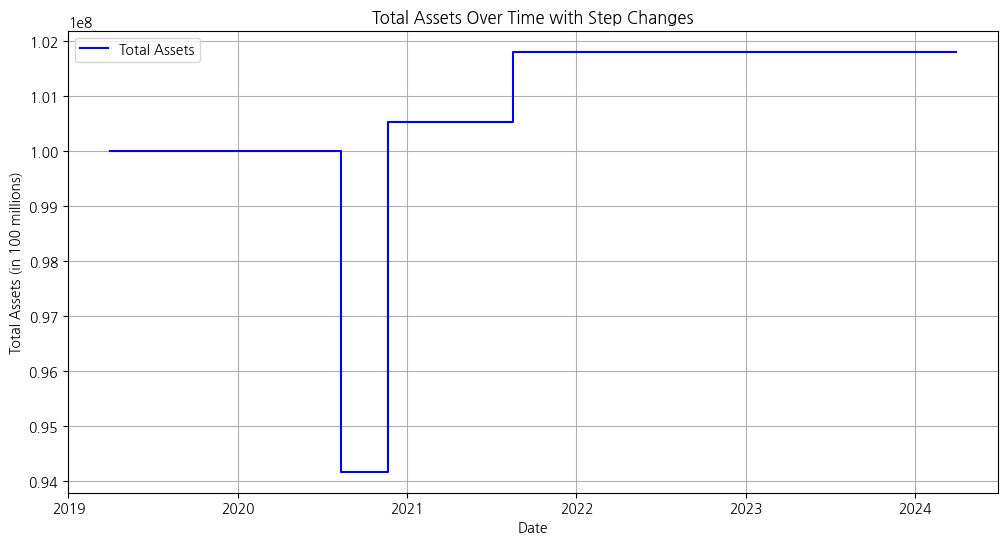

In [52]:
import pandas as pd
import matplotlib.pyplot as plt

# 날짜별로 수익 합산
daily_profit = matched_df.groupby('date')['profit'].sum().reset_index()

# 시작과 끝 날짜 추가
start_date = pd.DataFrame({'date': [pd.Timestamp('2019-04-01')], 'profit': [0]})
end_date = pd.DataFrame({'date': [pd.Timestamp('2024-03-29')], 'profit': [0]})

# 데이터프레임 병합
daily_profit = pd.concat([start_date, daily_profit, end_date]).reset_index(drop=True)

# 날짜별 누적 수익 계산
daily_profit['cumulative_profit'] = daily_profit['profit'].cumsum()

# 초기 자본금 설정
initial_capital = 100000000  # 1억 원

# 기초자산에 누적 수익 더하기
daily_profit['total_assets'] = initial_capital + daily_profit['cumulative_profit']

# 수익 그래프 그리기
plt.figure(figsize=(12, 6))
plt.step(daily_profit['date'], daily_profit['total_assets'],where='post', label='Total Assets', color='blue')
plt.title('Total Assets Over Time with Step Changes')
plt.xlabel('Date')
plt.ylabel('Total Assets (in 100 millions)')
plt.grid(True)
plt.legend()
plt.show()

In [53]:
daily_profit

date        profit  cumulative_profit  total_assets
0 2019-04-01  0.000000e+00       0.000000e+00  1.000000e+08
1 2020-08-10 -5.831986e+06      -5.831986e+06  9.416801e+07
2 2020-11-20  6.360500e+06       5.285131e+05  1.005285e+08
3 2021-08-18  1.283855e+06       1.812369e+06  1.018124e+08
4 2024-03-29  0.000000e+00       1.812369e+06  1.018124e+08

In [55]:
spread_all

[[Symbol Name
  2020-04-10    0.075245
  2020-04-13    0.017643
  2020-04-14    0.017343
  2020-04-16    0.024921
  2020-04-17    0.029697
                  ...   
  2024-03-25    0.014899
  2024-03-26   -0.031515
  2024-03-27   -0.016122
  2024-03-28   -0.028176
  2024-03-29   -0.050032
  Length: 979, dtype: float64],
 [Symbol Name
  2020-04-10    0.079798
  2020-04-13    0.061506
  2020-04-14    0.044563
  2020-04-16    0.033030
  2020-04-17    0.037301
                  ...   
  2024-03-25   -0.003721
  2024-03-26   -0.022681
  2024-03-27   -0.000579
  2024-03-28    0.003308
  2024-03-29   -0.012871
  Length: 979, dtype: float64],
 [Symbol Name
  2020-04-10    0.091813
  2020-04-13    0.036898
  2020-04-14    0.035656
  2020-04-16    0.028123
  2020-04-17    0.042573
                  ...   
  2024-03-25   -0.070560
  2024-03-26   -0.088096
  2024-03-27   -0.067875
  2024-03-28   -0.047906
  2024-03-29   -0.071626
  Length: 979, dtype: float64],
 [Symbol Name
  2020-04-10    0.08227

---